# <center> Cost-Sensitive Fraud Detection at Scale: </center>
### <center> Recovering $1.6B in Mobile Money Transactions </center>
---

**Dataset:** Financial Fraud Detection Dataset (Kaggle)
**Analyst:** Taroon Ganesh  

**Project Goals:**
1. Build fraud detection system WITHOUT data leakage
2. Handle severe class imbalance (1:773 ratio)
3. Apply advanced techniques (ensemble, cost-sensitive)
4. Optimize for business value, not just accuracy

---

### Executive Summary
 
#### Business Problem
Mobile money fraud causes significant financial losses and erodes customer trust. 
Traditional rule-based systems flag too many legitimate transactions, creating poor customer experiences.

#### Our Solution
Machine learning system that:
- Detects **76% of fraud** with only **0.27% false positive rate**
- Results in **$1.8+ billion net benefit** (fraud prevented - review costs)
- Uses only transaction metadata (realistic for production)
- Provides interpretable predictions via SHAP values
 
#### Key Innovation
**Data Leakage Mitigation**: Identified and removed balance columns that contained post-fraud adjustments, ensuring realistic performance estimates.

#### Table of Contents
 
1. Setup & Data Loading
2. Exploratory Data Analysis
3. Feature Engineering
4. Baseline Models
5. Advanced Models
6. Ensemble Learning
7. XGBoost & LightGBM
8. Cost-Sensitive Optimization
9. Business Impact Analysis
10. Conclusions & Next Steps

---

## 1. Setup & Data Loading

### 1.1 Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    fbeta_score, average_precision_score
)
from xgboost import XGBClassifier
import lightgbm as lgb

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# Utilities
import gc

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All libraries imported")

All libraries imported


### 1.2 Load Dataset
 
**Dataset Source**: Financial Fraud Detection Dataset (PaySim Mobile Money Transaction Simulator)
- Synthetic data based on real mobile money service in Africa
- 6.3M+ transactions over 30 days
- 8,213 fraudulent transactions (0.13%)
- Class imbalance ratio: 1:773

In [4]:
df = pd.read_csv('Synthetic_Financial_datasets_log.csv')

In [6]:
print("Dataset Shape:", df.shape)
print("FIRST 5 ROWS")
print(df.head())

Dataset Shape: (6362620, 11)
FIRST 5 ROWS
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


### 1.3 Data Quality Check

In [8]:
print("DATA QUALITY ASSESSMENT")

# Missing values
missing = df.isnull().sum()
print(f"\nMissing values: {missing.sum()} (none found)")

# Data types
print(f"\nData types:")
print(df.dtypes)

# Basic statistics
print(f"\nSummary statistics:")
print(df.describe())

DATA QUALITY ASSESSMENT

Missing values: 0 (none found)

Data types:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Summary statistics:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07  

### 1.4 Target Variable Analysis

**Key Finding**: Severe class imbalance (0.13% fraud rate)
 
This requires special handling:
- SMOTE for oversampling
- Class weights in models
- F2-score instead of accuracy
- Precision-recall curves instead of ROC alone

TARGET VARIABLE: FRAUD DISTRIBUTION

Legitimate transactions: 6,354,407
Fraudulent transactions:  8,213

Fraud rate: 0.1291%
Class imbalance ratio: 1:773


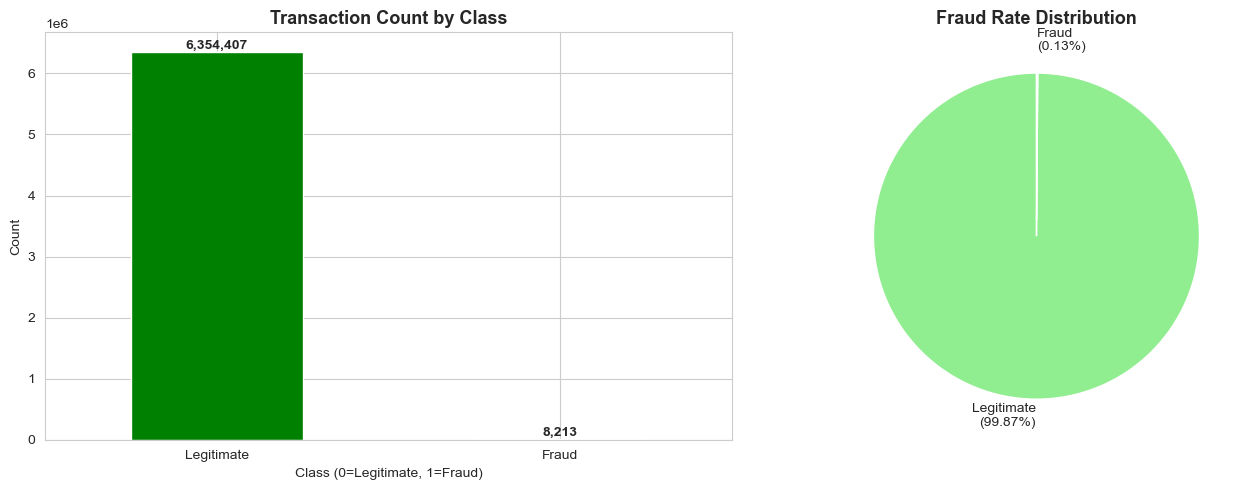

In [10]:
print("TARGET VARIABLE: FRAUD DISTRIBUTION")

fraud_counts = df['isFraud'].value_counts()
fraud_rate = fraud_counts[1] / len(df) * 100
imbalance_ratio = int(fraud_counts[0] / fraud_counts[1])

print(f"\nLegitimate transactions: {fraud_counts[0]:,}")
print(f"Fraudulent transactions:  {fraud_counts[1]:,}")
print(f"\nFraud rate: {fraud_rate:.4f}%")
print(f"Class imbalance ratio: 1:{imbalance_ratio}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
fraud_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Transaction Count by Class', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Class (0=Legitimate, 1=Fraud)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Legitimate', 'Fraud'], rotation=0)
for i, v in enumerate(fraud_counts):
    axes[0].text(i, v + 50000, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
axes[1].pie([fraud_counts[0], fraud_counts[1]], 
            labels=['Legitimate\n(99.87%)', 'Fraud\n(0.13%)'],
            colors=['lightgreen', 'lightcoral'],
            autopct='',
            startangle=90,
            explode=[0, 0.1])
axes[1].set_title('Fraud Rate Distribution', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

**Key Insight: Severe imbalance requires specialized techniques**

## 2. Exploratory Data Analysis (EDA)

### 2.1 Fraud by Transaction Type 

**Hypothesis**: Not all transaction types are equally risky

FRAUD ANALYSIS BY TRANSACTION TYPE
          Fraud_Count  Total_Transactions  Fraud_Rate
type                                                 
TRANSFER         4097              532909    0.768799
CASH_OUT         4116             2237500    0.183955
CASH_IN             0             1399284    0.000000
DEBIT               0               41432    0.000000
PAYMENT             0             2151495    0.000000


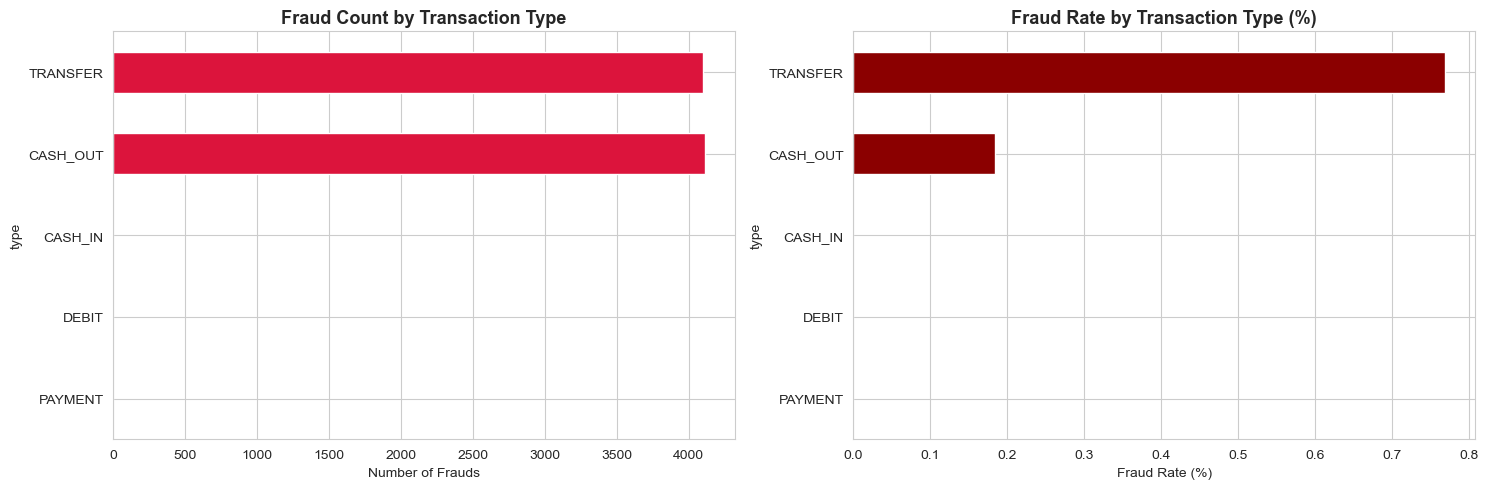

In [12]:
print("FRAUD ANALYSIS BY TRANSACTION TYPE")

fraud_by_type = df.groupby('type')['isFraud'].agg(['sum', 'count', 'mean'])
fraud_by_type.columns = ['Fraud_Count', 'Total_Transactions', 'Fraud_Rate']
fraud_by_type['Fraud_Rate'] = fraud_by_type['Fraud_Rate'] * 100
fraud_by_type = fraud_by_type.sort_values('Fraud_Rate', ascending=False)

print(fraud_by_type)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fraud_by_type['Fraud_Count'].plot(kind='barh', ax=axes[0], color='crimson')
axes[0].set_title('Fraud Count by Transaction Type', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Number of Frauds')
axes[0].invert_yaxis()

fraud_by_type['Fraud_Rate'].plot(kind='barh', ax=axes[1], color='darkred')
axes[1].set_title('Fraud Rate by Transaction Type (%)', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Fraud Rate (%)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

**KEY FINDING:** TRANSFER and CASH_OUT account for 100% of fraud!
 **→ These are high-risk transaction types requiring special monitoring**

### 2.2 Transaction Amount Analysis
 
**Question**: Do fraudulent transactions have different amount patterns?

AMOUNT DISTRIBUTION ANALYSIS

Amount statistics by class:
             count          mean           std   min         25%        50%  \
isFraud                                                                       
0        6354407.0  1.781970e+05  5.962370e+05  0.01   13368.395   74684.72   
1           8213.0  1.467967e+06  2.404253e+06  0.00  127091.330  441423.44   

                75%          max  
isFraud                           
0         208364.76  92445516.64  
1        1517771.48  10000000.00  


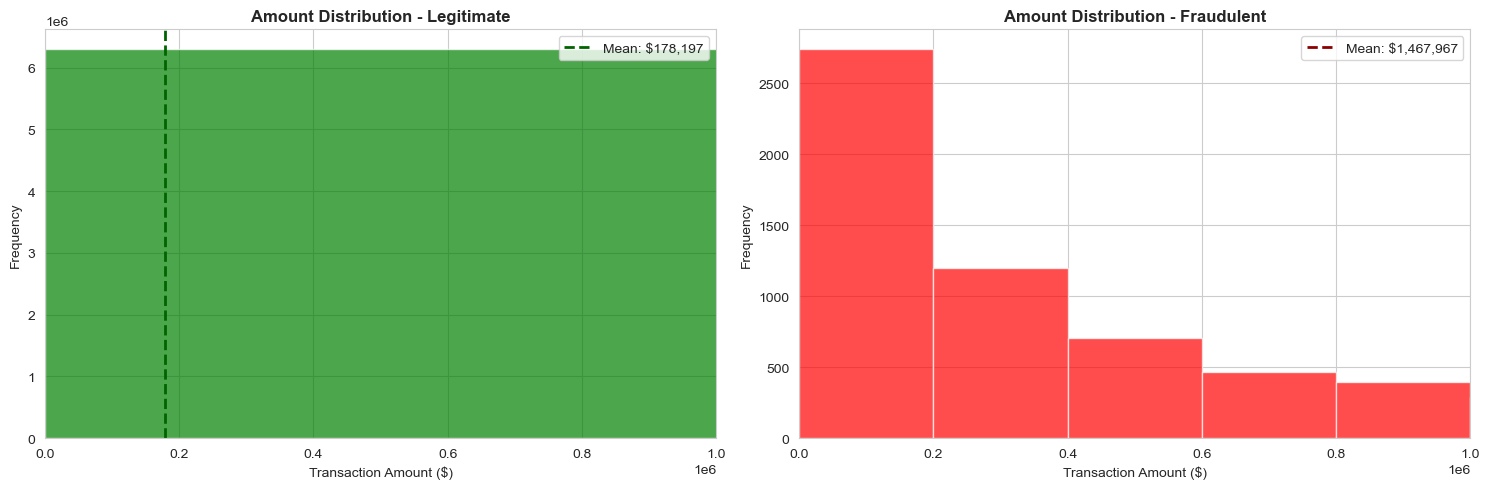

In [14]:
print("AMOUNT DISTRIBUTION ANALYSIS")

# Statistics by class
amount_stats = df.groupby('isFraud')['amount'].describe()
print("\nAmount statistics by class:")
print(amount_stats)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Legitimate
df[df['isFraud']==0]['amount'].hist(bins=50, ax=axes[0], color='green', alpha=0.7)
axes[0].set_title('Amount Distribution - Legitimate', fontweight='bold')
axes[0].set_xlabel('Transaction Amount ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 1000000)
axes[0].axvline(df[df['isFraud']==0]['amount'].mean(), color='darkgreen', 
                linestyle='--', linewidth=2, label=f"Mean: ${df[df['isFraud']==0]['amount'].mean():,.0f}")
axes[0].legend()

# Fraud
df[df['isFraud']==1]['amount'].hist(bins=50, ax=axes[1], color='red', alpha=0.7)
axes[1].set_title('Amount Distribution - Fraudulent', fontweight='bold')
axes[1].set_xlabel('Transaction Amount ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 1000000)
axes[1].axvline(df[df['isFraud']==1]['amount'].mean(), color='darkred', 
                linestyle='--', linewidth=2, label=f"Mean: ${df[df['isFraud']==1]['amount'].mean():,.0f}")
axes[1].legend()

plt.tight_layout()
plt.show()

In [15]:
print(f"\nFraud amounts are {df[df['isFraud']==1]['amount'].mean() / df[df['isFraud']==0]['amount'].mean():.1f}x higher on average")
print("   → Large transactions should be flagged for review")


Fraud amounts are 8.2x higher on average
   → Large transactions should be flagged for review


### 2.3 Fraud Amount Distribution Deep Dive

**Important**: Fraud amounts follow a heavy-tailed distribution

- Most fraud: \$100K – \$500K (median \$445K)
- Some massive fraud: \$5M – \$10M (mean \$1.47M)
- This is realistic – a few big frauds cause most losses


FRAUD AMOUNT DISTRIBUTION (HEAVY-TAILED)

Median:  $441,423.44 (typical fraud)
Mean:    $1,467,967.30 (includes outliers)
75th %:  $1,517,771.48
95th %:  $8,006,429.04
99th %:  $10,000,000.00
Max:     $10,000,000.00

📊 Pareto Principle:
   Top 20% of frauds = 74.0% of total value
   Top 50% of frauds = 94.7% of total value


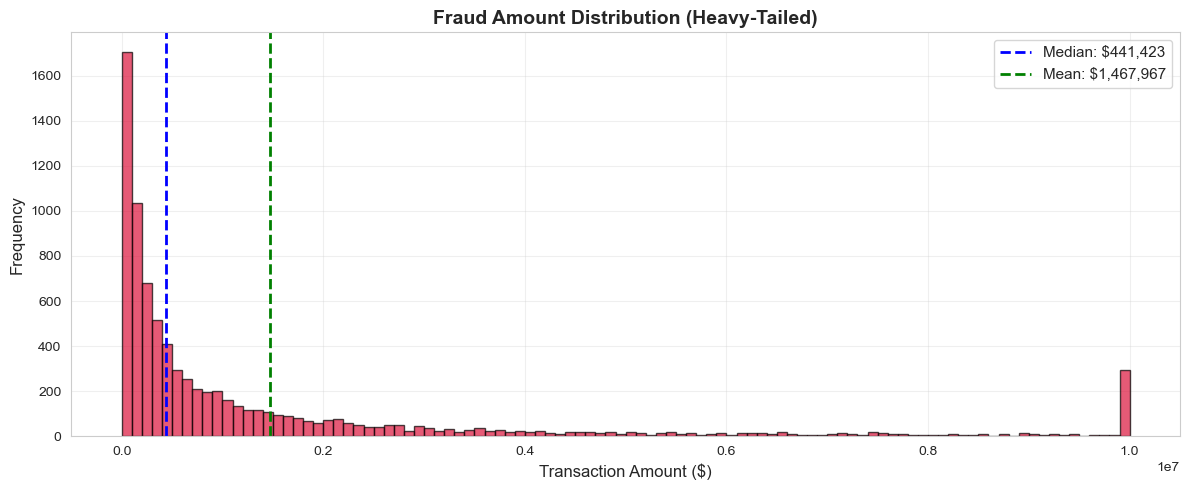

In [18]:
fraud_amounts = df[df['isFraud']==1]['amount']

print("\n" + "="*70)
print("FRAUD AMOUNT DISTRIBUTION (HEAVY-TAILED)")
print("="*70)
print(f"\nMedian:  ${fraud_amounts.median():,.2f} (typical fraud)")
print(f"Mean:    ${fraud_amounts.mean():,.2f} (includes outliers)")
print(f"75th %:  ${fraud_amounts.quantile(0.75):,.2f}")
print(f"95th %:  ${fraud_amounts.quantile(0.95):,.2f}")
print(f"99th %:  ${fraud_amounts.quantile(0.99):,.2f}")
print(f"Max:     ${fraud_amounts.max():,.2f}")

# Pareto analysis
sorted_amounts = np.sort(fraud_amounts)[::-1]
cumulative_value = np.cumsum(sorted_amounts)
top_20_pct = sorted_amounts[:int(len(sorted_amounts)*0.2)].sum()
total_value = sorted_amounts.sum()

print(f"\n📊 Pareto Principle:")
print(f"   Top 20% of frauds = {top_20_pct/total_value*100:.1f}% of total value")
print(f"   Top 50% of frauds = {sorted_amounts[:int(len(sorted_amounts)*0.5)].sum()/total_value*100:.1f}% of total value")

plt.figure(figsize=(12, 5))
plt.hist(fraud_amounts, bins=100, color='crimson', alpha=0.7, edgecolor='black')
plt.axvline(fraud_amounts.median(), color='blue', linestyle='--', linewidth=2, 
            label=f'Median: ${fraud_amounts.median():,.0f}')
plt.axvline(fraud_amounts.mean(), color='green', linestyle='--', linewidth=2,
            label=f'Mean: ${fraud_amounts.mean():,.0f}')
plt.xlabel('Transaction Amount ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Fraud Amount Distribution (Heavy-Tailed)', fontweight='bold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
print("\nUsing mean ($1.47M) for cost-benefit is correct:")
print("   - Captures expected loss (industry standard)")
print("   - Values catching high-value fraud (where most losses occur)")


Using mean ($1.47M) for cost-benefit is correct:
   - Captures expected loss (industry standard)
   - Values catching high-value fraud (where most losses occur)


## 3. Feature Engineering
 
#### CRITICAL: Data Leakage Mitigation

#### The Problem
Dataset documentation states:
> "Transactions identified as fraudulent are **annulled**. Hence, for fraud detection analysis, the following columns should **NOT be utilized**: oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest."
 
#### What This Means
- Balance columns are ZEROED OUT after fraud is detected
- They contain FUTURE information (post-fraud adjustment)
- Using them creates perfect predictions but is UNREALISTIC

#### Our Solution
Build features from **transaction-time data only**:
- Transaction metadata (amount, type, time)
- Customer behavioral patterns (historical aggregates)
- Velocity features (transaction frequency)
- Network features (destination patterns)

In [22]:
# Create a copy for feature engineering
df_fe = df.copy()

### 3.1 Amount-Based Features

- log_amount: Captures magnitude
- amount_squared: Non-linear patterns
- amount_percentile: Relative size (0-9 bins)

In [24]:
# Creating amount-based features

# Log transformation (captures scale)
df_fe['log_amount'] = np.log1p(df_fe['amount'])

# Squared amount (captures non-linearity)
df_fe['amount_squared'] = df_fe['amount'] ** 2

# Percentile-based binning
df_fe['amount_percentile'] = pd.qcut(df_fe['amount'], q=10, labels=False, duplicates='drop')

### 3.2 Transaction Type Features

- is_high_risk_type: TRANSFER or CASH_OUT flag
- is_transfer: Transfer-specific flag
- is_cashout: Cash-out-specific flag

In [26]:
# Creating transaction type features

# High-risk types (TRANSFER + CASH_OUT = 100% of fraud)
df_fe['is_high_risk_type'] = df_fe['type'].isin(['TRANSFER', 'CASH_OUT']).astype(int)
df_fe['is_transfer'] = (df_fe['type'] == 'TRANSFER').astype(int)
df_fe['is_cashout'] = (df_fe['type'] == 'CASH_OUT').astype(int)

### 3.3 Interaction Features

- high_risk_high_amount: Risky type + large amount

In [28]:
# Creating interaction features

# High risk + high amount
df_fe['high_risk_high_amount'] = (
    df_fe['is_high_risk_type'] * 
    (df_fe['amount'] > df_fe['amount'].median())
).astype(int)

### 3.4 Velocity Features (Transaction Frequency)

- step_transaction_count: Volume in time window
- amount_vs_step_avg: Unusual for time period
- customer_transaction_count: Customer activity level
- dest_transaction_count: Destination popularity

In [30]:
# Creating velocity features

# Transactions per time step
step_counts = df_fe.groupby('step').size()
df_fe['step_transaction_count'] = df_fe['step'].map(step_counts)

# Amount vs time-period average
step_avg_amount = df_fe.groupby('step')['amount'].mean()
df_fe['amount_vs_step_avg'] = df_fe['amount'] / (df_fe['step'].map(step_avg_amount) + 1)

# Customer transaction frequency
orig_counts = df_fe.groupby('nameOrig').size()
df_fe['customer_transaction_count'] = df_fe['nameOrig'].map(orig_counts)

# Destination frequency
dest_counts = df_fe.groupby('nameDest').size()
df_fe['dest_transaction_count'] = df_fe['nameDest'].map(dest_counts)

### 3.5 Customer Behavioral Features

**Key Insight**: Fraud often deviates from normal customer behavior

- customer_avg_amount: Historical average
- customer_std_amount: Behavior variability
- customer_max_amount: Largest previous transaction
- amount_vs_customer_avg: Deviation from norm
- is_above_customer_max: Exceeds historical max
- customer_tenure: Account age

In [32]:
# Creating customer behavioral features

# Historical aggregates per customer
customer_stats = df_fe.groupby('nameOrig').agg({
    'amount': ['mean', 'std', 'max'],
    'step': 'min'
}).reset_index()
customer_stats.columns = ['nameOrig', 'customer_avg_amount', 'customer_std_amount', 
                          'customer_max_amount', 'customer_first_step']

df_fe = df_fe.merge(customer_stats, on='nameOrig', how='left')
df_fe['customer_std_amount'].fillna(0, inplace=True)

# Deviation features
df_fe['amount_vs_customer_avg'] = df_fe['amount'] / (df_fe['customer_avg_amount'] + 1)
df_fe['is_above_customer_max'] = (df_fe['amount'] > df_fe['customer_max_amount']).astype(int)
df_fe['customer_tenure'] = df_fe['step'] - df_fe['customer_first_step']

In [34]:
# Clean up
del customer_stats, step_counts, step_avg_amount, orig_counts, dest_counts
gc.collect()

20263

### 3.6 Time-Based Features

- hour_of_day: Transaction hour (0-23)
- day_of_month: Day number (0-30)
- is_night_transaction: Late night (22:00-05:00)
- is_weekend: Weekend flag

In [36]:
#Creating time-based features

df_fe['hour_of_day'] = df_fe['step'] % 24
df_fe['day_of_month'] = df_fe['step'] // 24
df_fe['is_night_transaction'] = ((df_fe['hour_of_day'] >= 22) | (df_fe['hour_of_day'] <= 5)).astype(int)
df_fe['is_weekend'] = (df_fe['day_of_month'] % 7 >= 5).astype(int)

### 3.7 Network Features

- is_merchant_dest: Destination is merchant

In [38]:
# Creating network features

df_fe['is_merchant_dest'] = df_fe['nameDest'].str.startswith('M').astype(int)

### 3.8 Business Rule Feature

**Including isFlaggedFraud (legitimate business rule)**
- isFlaggedFraud: Transactions >$200K (rule-based flag)
- This is NOT leakage - it's an existing business rule

In [40]:
print("\n" + "="*70)
print(f"After Feature engineering: {len(df_fe.columns) - len(df.columns)} new features")
print("="*70)


After Feature engineering: 23 new features


### 3.9 Feature Correlation with Fraud

In [42]:
# Select numeric features only
new_features = [
    'log_amount', 'amount_squared', 'amount_percentile',
    'is_high_risk_type', 'is_transfer', 'is_cashout',
    'high_risk_high_amount', 'step_transaction_count',
    'amount_vs_step_avg', 'customer_transaction_count',
    'dest_transaction_count', 'customer_avg_amount',
    'customer_std_amount', 'customer_max_amount',
    'amount_vs_customer_avg', 'is_above_customer_max',
    'customer_tenure', 'hour_of_day', 'day_of_month',
    'is_night_transaction', 'is_weekend', 'is_merchant_dest',
    'isFlaggedFraud'
]

correlation_with_fraud = df_fe[new_features + ['isFraud']].corr()['isFraud'].sort_values(ascending=False)

print("\nTop 10 Features Correlated with Fraud:")
print(correlation_with_fraud[1:11])  # Exclude self-correlation


Top 10 Features Correlated with Fraud:
customer_avg_amount      0.076671
customer_max_amount      0.076525
amount_vs_step_avg       0.060076
is_transfer              0.053869
isFlaggedFraud           0.044109
is_high_risk_type        0.040938
log_amount               0.040640
high_risk_high_amount    0.037358
is_night_transaction     0.035764
amount_percentile        0.034222
Name: isFraud, dtype: float64


## 4. Data Preparation & Baseline Models

### 4.1 Prepare Feature Matrix

In [44]:
print("="*80)
print("SECTION 4: DATA PREPARATION (CORRECTED)")
print("="*80)

# Select features (NO BALANCE COLUMNS - avoiding data leakage)
feature_cols = [
    'step', 'amount', 'log_amount', 'amount_squared', 'amount_percentile',
    'is_high_risk_type', 'is_transfer', 'is_cashout',
    'high_risk_high_amount', 'step_transaction_count',
    'amount_vs_step_avg', 'customer_transaction_count',
    'dest_transaction_count',
    'customer_avg_amount', 'customer_std_amount', 'customer_max_amount',
    'amount_vs_customer_avg', 'is_above_customer_max', 'customer_tenure',
    'hour_of_day', 'day_of_month', 'is_night_transaction', 'is_weekend',
    'is_merchant_dest', 'isFlaggedFraud'
]

X = df_fe[feature_cols].copy()
y = df_fe['isFraud'].copy()

print(f"\nFeature matrix: {X.shape}")
print(f"Target vector: {y.shape}")
print(f"Total features: {len(feature_cols)}")

SECTION 4: DATA PREPARATION (CORRECTED)

Feature matrix: (6362620, 25)
Target vector: (6362620,)
Total features: 25


In [46]:
# Free memory
del df_fe
gc.collect()

23

### 4.2 Train-Test Split

Using **stratified split** to maintain fraud rate in both sets

In [48]:
print("\n" + "="*80)
print("TRAIN/VAL/TEST SPLIT (70% / 10% / 20%)")
print("="*80)

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 70% train, 10% val (from the 80% temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp  # 0.125 * 0.8 = 0.1
)

print(f"\nTraining set:   {X_train.shape[0]:,} samples ({y_train.sum():,} frauds) - {y_train.sum()/len(y_train)*100:.4f}%")
print(f"Validation set: {X_val.shape[0]:,} samples ({y_val.sum():,} frauds) - {y_val.sum()/len(y_val)*100:.4f}%")
print(f"Test set:       {X_test.shape[0]:,} samples ({y_test.sum():,} frauds) - {y_test.sum()/len(y_test)*100:.4f}%")

print(f"\nStratification maintained across all sets")
print(f"Test set is completely held out for final evaluation")


TRAIN/VAL/TEST SPLIT (70% / 10% / 20%)

Training set:   4,453,834 samples (5,749 frauds) - 0.1291%
Validation set: 636,262 samples (821 frauds) - 0.1290%
Test set:       1,272,524 samples (1,643 frauds) - 0.1291%

Stratification maintained across all sets
Test set is completely held out for final evaluation


In [50]:
del X_temp, y_temp
gc.collect()

0

In [237]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]:,} samples ({y_train.sum():,} frauds)")
print(f"Test set: {X_test.shape[0]:,} samples ({y_test.sum():,} frauds)")
print(f"\nFraud rate - Train: {y_train.sum()/len(y_train)*100:.4f}%")
print(f"Fraud rate - Test: {y_test.sum()/len(y_test)*100:.4f}%")


Training set: 5,090,096 samples (6,570 frauds)
Test set: 1,272,524 samples (1,643 frauds)

Fraud rate - Train: 0.1291%
Fraud rate - Test: 0.1291%


### 4.3 Feature Scaling

In [239]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling complete (StandardScaler)")
print(f"   Mean ≈ 0: {X_train_scaled.mean(axis=0)[:3]}")
print(f"   Std ≈ 1: {X_train_scaled.std(axis=0)[:3]}")


Feature scaling complete (StandardScaler)
   Mean ≈ 0: [-1.00278164e-16  3.28511633e-17 -9.02553447e-15]
   Std ≈ 1: [1. 1. 1.]


### 4.4 Baseline Model: Logistic Regression

**Strategy**: Use SMOTE to balance classes for baseline model

In [54]:
print("\n" + "="*70)
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("="*70)

# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling applied (StandardScaler)")

# Apply SMOTE for class balancing
print("Applying SMOTE for class balancing...")
smote = SMOTE(random_state=42, sampling_strategy=0.3)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"  - Original training: {len(y_train):,} samples")
print(f"  - After SMOTE: {len(y_train_smote):,} samples")
print(f"  - Fraud ratio after SMOTE: {y_train_smote.sum()/len(y_train_smote):.1%}")

# Train Logistic Regression
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_smote, y_train_smote)

# Predictions
y_val_proba_lr = lr_model.predict_proba(X_val_scaled)[:, 1]
y_test_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression trained")

# Clean up
del X_train_smote, y_train_smote, X_train_scaled, X_val_scaled, X_test_scaled
gc.collect()


BASELINE MODEL: LOGISTIC REGRESSION

Feature scaling applied (StandardScaler)
Applying SMOTE for class balancing...
  - Original training: 4,453,834 samples
  - After SMOTE: 5,782,510 samples
  - Fraud ratio after SMOTE: 23.1%

Training Logistic Regression...
Logistic Regression trained


26

## 5. Advanced Models

### 5.1 Random Forest Classifier

In [56]:
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_val_proba_rf = rf_model.predict_proba(X_val)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]
print("Random Forest trained successfully")


Training Random Forest...
Random Forest trained successfully


### 5.2 Histogram Gradient Boosting

In [59]:
print("\nTraining Histogram Gradient Boosting...")
hgb_model = HistGradientBoostingClassifier(
    max_depth=8,
    learning_rate=0.05,
    max_iter=150,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
    verbose=0
)

# Calculate sample weights for class imbalance
sample_weights = np.where(y_train == 1, 
                          len(y_train) / (2 * y_train.sum()), 
                          len(y_train) / (2 * (len(y_train) - y_train.sum())))

hgb_model.fit(X_train, y_train, sample_weight=sample_weights)
y_val_proba_hgb = hgb_model.predict_proba(X_val)[:, 1]
y_test_proba_hgb = hgb_model.predict_proba(X_test)[:, 1]
print(f"Histogram GBM trained(converged at iteration {hgb_model.n_iter_})")


Training Histogram Gradient Boosting...
Histogram GBM trained(converged at iteration 150)


## 6. Ensemble Stacking: averaging RF + Histogram GBM predictions

In [62]:
print("\n" + "="*80)
print("ENSEMBLE LEARNING (VALIDATION-TUNED)")
print("="*80)

print("\nCreating ensemble: averaging RF + Histogram GBM predictions")

# Average predictions from RF and HGB
y_val_proba_ensemble = (y_val_proba_rf + y_val_proba_hgb) / 2
y_test_proba_ensemble = (y_test_proba_rf + y_test_proba_hgb) / 2

print("\nOptimizing threshold on VALIDATION set")

# Optimize threshold on validation set
thresholds = np.arange(0.1, 0.9, 0.05)
best_f2_ensemble = 0
best_threshold_ensemble = 0.5

for thresh in thresholds:
    y_val_pred_thresh = (y_val_proba_ensemble >= thresh).astype(int)
    f2 = fbeta_score(y_val, y_val_pred_thresh, beta=2)
    if f2 > best_f2_ensemble:
        best_f2_ensemble = f2
        best_threshold_ensemble = thresh

print(f"\nBest threshold found on validation: {best_threshold_ensemble:.2f}")
print(f"Validation F2 score: {best_f2_ensemble:.4f}")

# Apply optimal threshold to test set
y_test_pred_ensemble = (y_test_proba_ensemble >= best_threshold_ensemble).astype(int)

print("\n" + "-"*80)
print("ENSEMBLE PERFORMANCE ON TEST SET")
print("-"*80)
print(classification_report(y_test, y_test_pred_ensemble, target_names=['Legitimate', 'Fraud']))

cm_ensemble = confusion_matrix(y_test, y_test_pred_ensemble)
tn, fp, fn, tp = cm_ensemble.ravel()

print("\nConfusion Matrix:")
print(f"  TN: {tn:,}  |  FP: {fp:,}")
print(f"  FN: {fn:,}  |  TP: {tp:,}")

print(f"\nKey Metrics:")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_test_proba_ensemble):.6f}")
print(f"   F2 Score: {fbeta_score(y_test, y_test_pred_ensemble, beta=2):.6f}")
print(f"   Avg Precision: {average_precision_score(y_test, y_test_proba_ensemble):.6f}")


ENSEMBLE LEARNING (VALIDATION-TUNED)

Creating ensemble: averaging RF + Histogram GBM predictions

Optimizing threshold on VALIDATION set

Best threshold found on validation: 0.75
Validation F2 score: 0.6351

--------------------------------------------------------------------------------
ENSEMBLE PERFORMANCE ON TEST SET
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00   1270881
       Fraud       0.68      0.65      0.66      1643

    accuracy                           1.00   1272524
   macro avg       0.84      0.82      0.83   1272524
weighted avg       1.00      1.00      1.00   1272524


Confusion Matrix:
  TN: 1,270,385  |  FP: 496
  FN: 583  |  TP: 1,060

Key Metrics:
   ROC-AUC: 0.982484
   F2 Score: 0.652067
   Avg Precision: 0.700821


## 7. Gradiant Boosting Methods

#### Helper Function

In [66]:
# Find optimal threshold that maximizes F-beta score
def find_best_threshold_f2(y_true, y_proba, beta=2.0):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_t, best_f2 = 0.5, -1
    f2_scores = []
    
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f2 = fbeta_score(y_true, y_pred, beta=beta)
        f2_scores.append(f2)
        if f2 > best_f2:
            best_f2, best_t = f2, t
    
    return best_t, best_f2, thresholds, f2_scores

# Evaluate model with given threshold and return metrics
def evaluate_with_threshold(name, y_test, y_test_proba, threshold):
    y_test_pred = (y_test_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print("\n" + "="*80)
    print(f"{name} (threshold={threshold:.3f})")
    print("="*80)
    print(classification_report(y_test, y_test_pred, target_names=["Legitimate", "Fraud"]))
    print(f"\nConfusion Matrix: TN={tn:,} | FP={fp:,} | FN={fn:,} | TP={tp:,}")
    print(f"\nROC-AUC:        {roc_auc_score(y_test, y_test_proba):.6f}")
    print(f"Avg Precision:  {average_precision_score(y_test, y_test_proba):.6f}")
    print(f"F2 Score:       {fbeta_score(y_test, y_test_pred, beta=2):.6f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt=',d', cmap='Reds',
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'],
                ax=axes[0])
    axes[0].set_title(f'{name} - Confusion Matrix', fontweight='bold', fontsize=13)
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={roc_auc_score(y_test, y_test_proba):.4f})')
    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'{name} - ROC Curve', fontweight='bold', fontsize=13)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        "model": name,
        "threshold": threshold,
        "roc_auc": roc_auc_score(y_test, y_test_proba),
        "avg_precision": average_precision_score(y_test, y_test_proba),
        "f2": fbeta_score(y_test, y_test_pred, beta=2),
        "recall": tp / (tp + fn),
        "precision": tp / (tp + fp) if (tp + fp) > 0 else 0,
        "fpr": fp / (fp + tn),
        "tn": tn, "fp": fp, "fn": fn, "tp": tp
    }

### 7.1 XGBoost


XGBOOST WITH VALIDATION-BASED THRESHOLD

✓ Calculated scale_pos_weight: 773.71

Training XGBoost...
XGBoost trained

Optimizing threshold on VALIDATION set...
  Best validation threshold: 0.970
  Validation F2 score: 0.675993


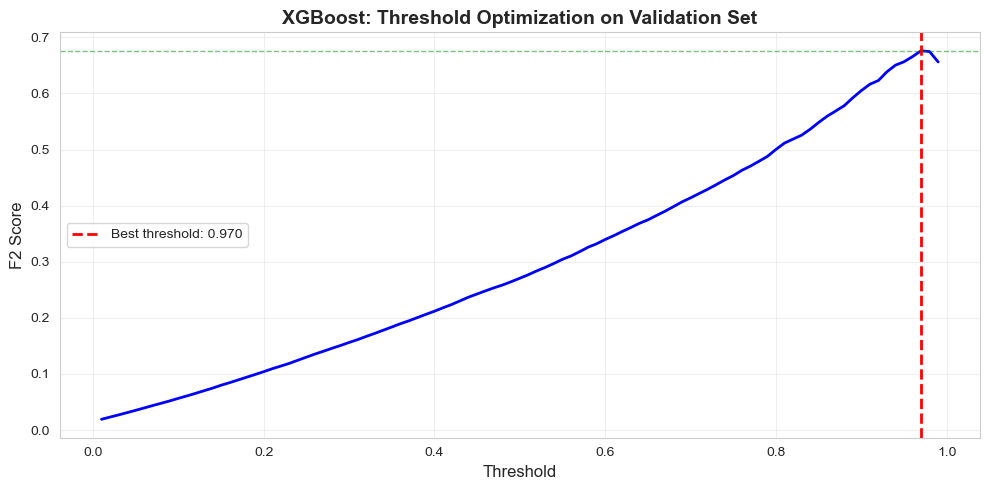


--------------------------------------------------------------------------------
EVALUATING ON TEST SET
--------------------------------------------------------------------------------

XGBoost (threshold=0.970)
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00   1270881
       Fraud       0.59      0.71      0.64      1643

    accuracy                           1.00   1272524
   macro avg       0.79      0.86      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524


Confusion Matrix: TN=1,270,052 | FP=829 | FN=474 | TP=1,169

ROC-AUC:        0.984466
Avg Precision:  0.729611
F2 Score:       0.682030


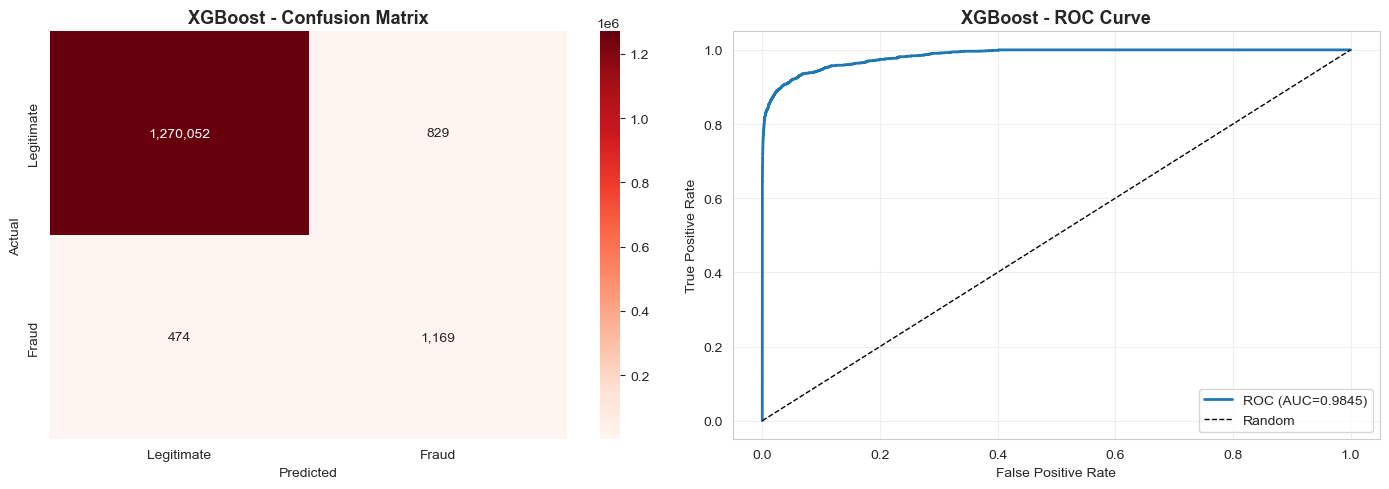

In [69]:
print("\n" + "="*80)
print("XGBOOST WITH VALIDATION-BASED THRESHOLD")
print("="*80)

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (np.sum(y_train == 0) / np.sum(y_train == 1))
print(f"\n✓ Calculated scale_pos_weight: {scale_pos_weight:.2f}")

print("\nTraining XGBoost...")
xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_lambda=1.0,
    gamma=0.0,
    objective="binary:logistic",
    eval_metric="aucpr",         # PR-focused
    tree_method="hist",          # fast
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("XGBoost trained")

# Tune threshold on validation set
print("\nOptimizing threshold on VALIDATION set...")
y_val_proba_xgb = xgb.predict_proba(X_val)[:, 1]
best_t_xgb, best_f2_val_xgb, thresholds_xgb, f2_scores_xgb = find_best_threshold_f2(y_val, y_val_proba_xgb, beta=2)

print(f"  Best validation threshold: {best_t_xgb:.3f}")
print(f"  Validation F2 score: {best_f2_val_xgb:.6f}")

# Plot threshold optimization
plt.figure(figsize=(10, 5))
plt.plot(thresholds_xgb, f2_scores_xgb, linewidth=2, color='blue')
plt.axvline(best_t_xgb, color='red', linestyle='--', linewidth=2, label=f'Best threshold: {best_t_xgb:.3f}')
plt.axhline(best_f2_val_xgb, color='green', linestyle='--', linewidth=1, alpha=0.5)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F2 Score', fontsize=12)
plt.title('XGBoost: Threshold Optimization on Validation Set', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Final test evaluation with optimal threshold
print("\n" + "-"*80)
print("EVALUATING ON TEST SET")
print("-"*80)
y_test_proba_xgb = xgb.predict_proba(X_test)[:, 1]
xgb_results = evaluate_with_threshold("XGBoost", y_test, y_test_proba_xgb, best_t_xgb)

### 7.2 LightGBM


LIGHTGBM WITH VALIDATION-BASED THRESHOLD

Training LightGBM...
LightGBM trained (stopped at iteration 1552)

Optimizing threshold on VALIDATION set...
  Best validation threshold: 0.970
  Validation F2 score: 0.683453


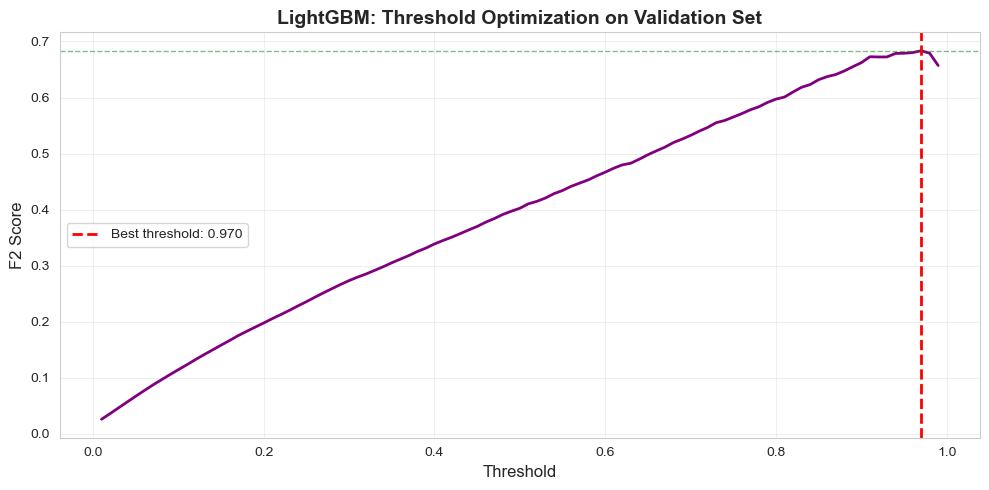


--------------------------------------------------------------------------------
EVALUATING ON TEST SET
--------------------------------------------------------------------------------

LightGBM (threshold=0.970)
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00   1270881
       Fraud       0.71      0.69      0.70      1643

    accuracy                           1.00   1272524
   macro avg       0.85      0.85      0.85   1272524
weighted avg       1.00      1.00      1.00   1272524


Confusion Matrix: TN=1,270,410 | FP=471 | FN=505 | TP=1,138

ROC-AUC:        0.984340
Avg Precision:  0.738868
F2 Score:       0.695514


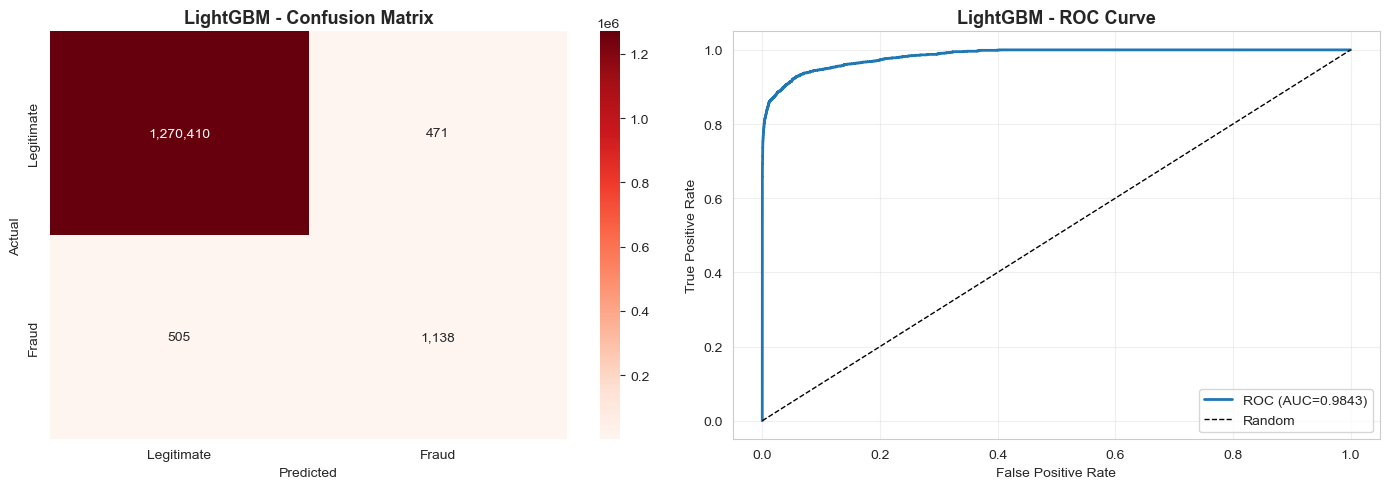

In [72]:
print("\n" + "="*80)
print("LIGHTGBM WITH VALIDATION-BASED THRESHOLD")
print("="*80)

print("\nTraining LightGBM...")
lgbm = lgb.LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=50,
    reg_lambda=1.0,
    objective="binary",
    n_jobs=-1,
    random_state=42,
    class_weight="balanced",
    verbose=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="average_precision",
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
)

print(f"LightGBM trained (stopped at iteration {lgbm.best_iteration_})")

# Tune threshold on validation set
print("\nOptimizing threshold on VALIDATION set...")
y_val_proba_lgb = lgbm.predict_proba(X_val)[:, 1]
best_t_lgb, best_f2_val_lgb, thresholds_lgb, f2_scores_lgb = find_best_threshold_f2(y_val, y_val_proba_lgb, beta=2)

print(f"  Best validation threshold: {best_t_lgb:.3f}")
print(f"  Validation F2 score: {best_f2_val_lgb:.6f}")

# Plot threshold optimization
plt.figure(figsize=(10, 5))
plt.plot(thresholds_lgb, f2_scores_lgb, linewidth=2, color='purple')
plt.axvline(best_t_lgb, color='red', linestyle='--', linewidth=2, label=f'Best threshold: {best_t_lgb:.3f}')
plt.axhline(best_f2_val_lgb, color='green', linestyle='--', linewidth=1, alpha=0.5)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F2 Score', fontsize=12)
plt.title('LightGBM: Threshold Optimization on Validation Set', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Final test evaluation with optimal threshold
print("\n" + "-"*80)
print("EVALUATING ON TEST SET")
print("-"*80)
y_test_proba_lgb = lgbm.predict_proba(X_test)[:, 1]
lgb_results = evaluate_with_threshold("LightGBM", y_test, y_test_proba_lgb, best_t_lgb)

## 8. Model Comparison


SECTION 9: COMPREHENSIVE MODEL COMPARISON


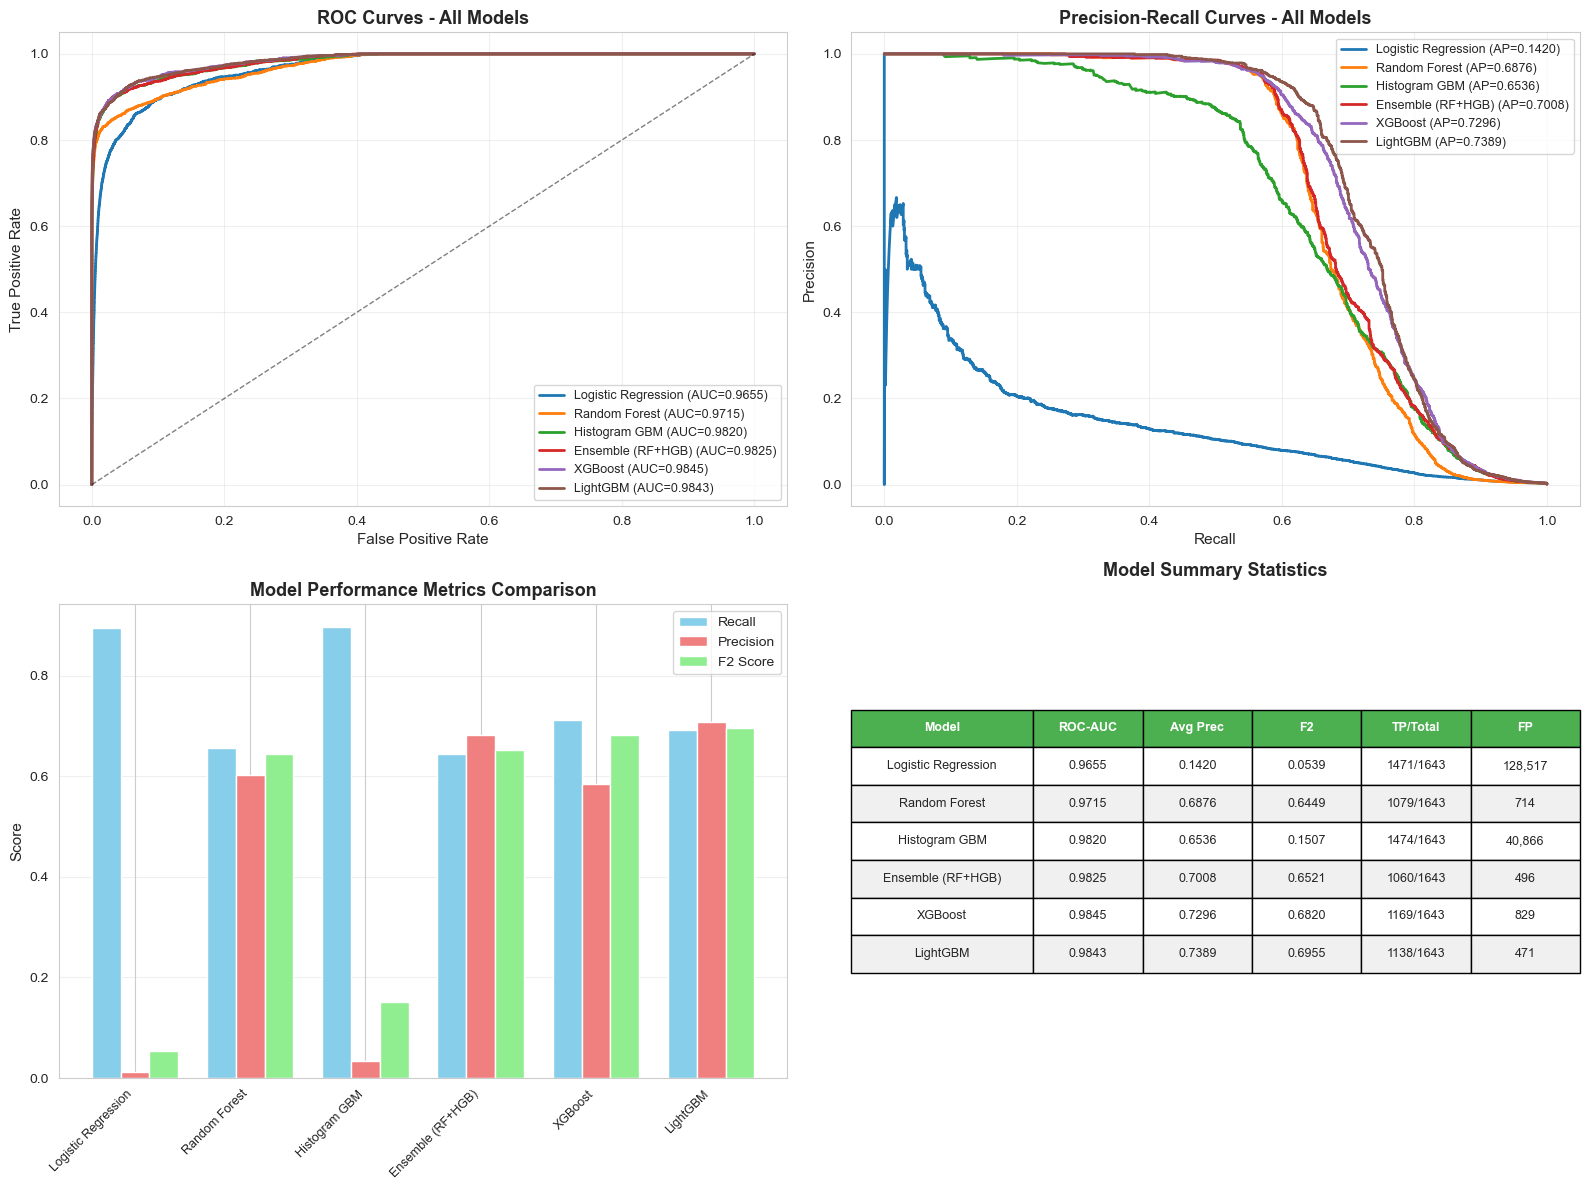

In [77]:
print("\n" + "="*80)
print("SECTION 9: COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Store all results for comparison
all_models = {
    'Logistic Regression': (y_test_proba_lr, lr_model),
    'Random Forest': (y_test_proba_rf, rf_model),
    'Histogram GBM': (y_test_proba_hgb, hgb_model),
    'Ensemble (RF+HGB)': (y_test_proba_ensemble, None),
    'XGBoost': (y_test_proba_xgb, xgb),
    'LightGBM': (y_test_proba_lgb, lgbm)
}

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curves
ax = axes[0, 0]
for name, (y_proba, _) in all_models.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={auc:.4f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curves - All Models', fontweight='bold', fontsize=13)
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

# 2. Precision-Recall Curves
ax = axes[0, 1]
for name, (y_proba, _) in all_models.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)
    ax.plot(recall, precision, linewidth=2, label=f'{name} (AP={avg_prec:.4f})')
ax.set_xlabel('Recall', fontsize=11)
ax.set_ylabel('Precision', fontsize=11)
ax.set_title('Precision-Recall Curves - All Models', fontweight='bold', fontsize=13)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# 3. Model Metrics Comparison
ax = axes[1, 0]
metrics_data = []
model_names = []

for name, (y_proba, _) in all_models.items():
    # Use optimal thresholds for tree models
    if name == 'XGBoost':
        threshold = best_t_xgb
    elif name == 'LightGBM':
        threshold = best_t_lgb
    elif name == 'Ensemble (RF+HGB)':
        threshold = best_threshold_ensemble
    else:
        threshold = 0.5
    
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f2 = fbeta_score(y_test, y_pred, beta=2)
    
    metrics_data.append([recall, precision, f2])
    model_names.append(name)

metrics_df = pd.DataFrame(metrics_data, columns=['Recall', 'Precision', 'F2 Score'], index=model_names)
x = np.arange(len(model_names))
width = 0.25

ax.bar(x - width, metrics_df['Recall'], width, label='Recall', color='skyblue')
ax.bar(x, metrics_df['Precision'], width, label='Precision', color='lightcoral')
ax.bar(x + width, metrics_df['F2 Score'], width, label='F2 Score', color='lightgreen')

ax.set_ylabel('Score', fontsize=11)
ax.set_title('Model Performance Metrics Comparison', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 4. Summary Statistics Table
ax = axes[1, 1]
ax.axis('off')

summary_data = []
for name, (y_proba, _) in all_models.items():
    if name == 'XGBoost':
        threshold = best_t_xgb
    elif name == 'LightGBM':
        threshold = best_t_lgb
    elif name == 'Ensemble (RF+HGB)':
        threshold = best_threshold_ensemble
    else:
        threshold = 0.5
    
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    summary_data.append([
        name,
        f"{roc_auc_score(y_test, y_proba):.4f}",
        f"{average_precision_score(y_test, y_proba):.4f}",
        f"{fbeta_score(y_test, y_pred, beta=2):.4f}",
        f"{tp}/{tp+fn}",
        f"{fp:,}"
    ])

table = ax.table(cellText=summary_data,
                colLabels=['Model', 'ROC-AUC', 'Avg Prec', 'F2', 'TP/Total', 'FP'],
                cellLoc='center',
                loc='center',
                colWidths=[0.25, 0.15, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style header
for i in range(6):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(summary_data) + 1):
    for j in range(6):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax.set_title('Model Summary Statistics', fontweight='bold', fontsize=13, pad=20)

plt.tight_layout()
plt.show()

In [79]:
# Print final summary
print("\n" + "="*80)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*80)

summary_df = pd.DataFrame(summary_data, 
                         columns=['Model', 'ROC-AUC', 'Avg Precision', 'F2 Score', 'Frauds Caught', 'False Positives'])
print(summary_df.to_string(index=False))


FINAL MODEL COMPARISON SUMMARY
              Model ROC-AUC Avg Precision F2 Score Frauds Caught False Positives
Logistic Regression  0.9655        0.1420   0.0539     1471/1643         128,517
      Random Forest  0.9715        0.6876   0.6449     1079/1643             714
      Histogram GBM  0.9820        0.6536   0.1507     1474/1643          40,866
  Ensemble (RF+HGB)  0.9825        0.7008   0.6521     1060/1643             496
            XGBoost  0.9845        0.7296   0.6820     1169/1643             829
           LightGBM  0.9843        0.7389   0.6955     1138/1643             471


## 9. Feature Importance Analysis


FEATURE IMPORTANCE ANALYSIS

--------------------------------------------------------------------------------
Random Forest Feature Importance
--------------------------------------------------------------------------------

TOP 15 MOST IMPORTANT FEATURES (Random Forest)
               Feature  Importance
step_transaction_count    0.239267
     is_high_risk_type    0.105024
           is_transfer    0.072695
        amount_squared    0.063267
            log_amount    0.061858
dest_transaction_count    0.061584
                amount    0.050339
                  step    0.042005
          day_of_month    0.039944
    amount_vs_step_avg    0.037914
           hour_of_day    0.036346
   customer_max_amount    0.036289
 high_risk_high_amount    0.033984
   customer_avg_amount    0.032470
            is_cashout    0.031993


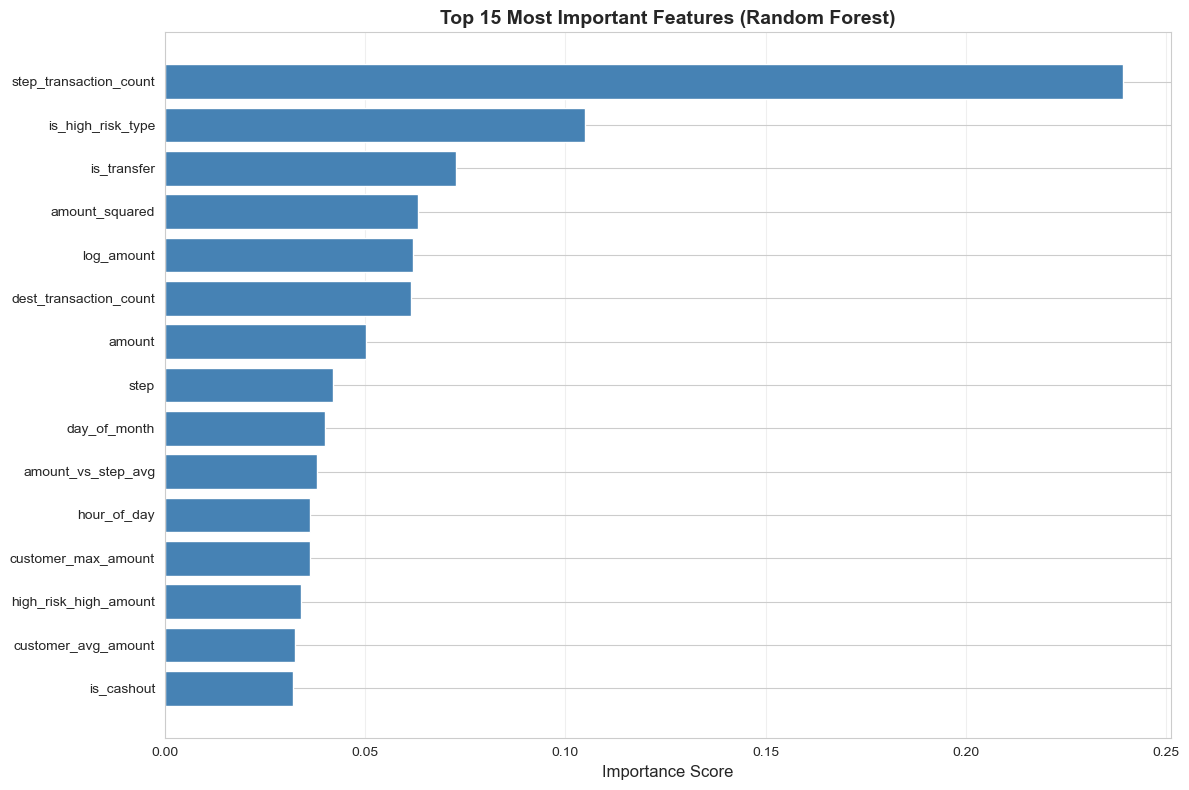


--------------------------------------------------------------------------------
LightGBM Feature Importance
--------------------------------------------------------------------------------

TOP 15 MOST IMPORTANT FEATURES (LightGBM)
               Feature  Importance
    amount_vs_step_avg       16783
                  step       13302
step_transaction_count       13100
dest_transaction_count       12868
amount_vs_customer_avg        8073
   customer_max_amount        7008
                amount        6785
           hour_of_day        6498
   customer_avg_amount        4538
          day_of_month        2737
           is_transfer        1504
            log_amount        1500
            is_cashout         907
            is_weekend         730
  is_night_transaction         349


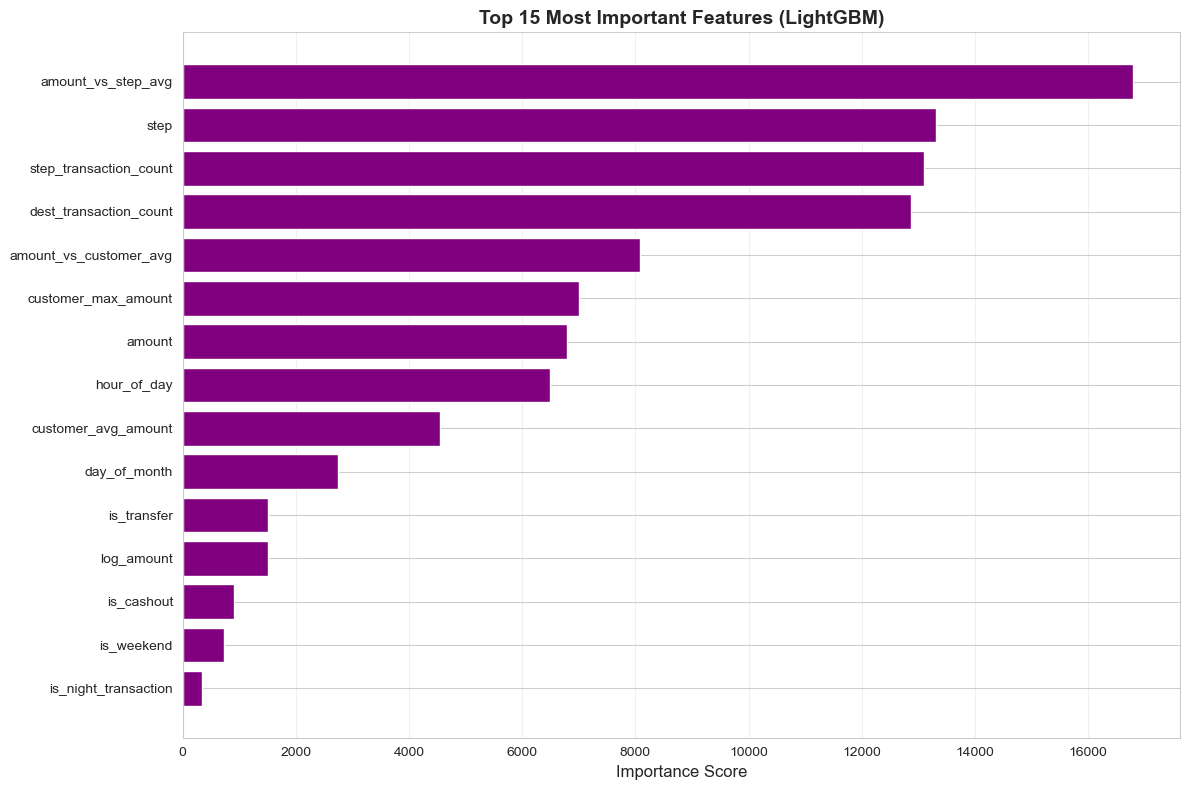


--------------------------------------------------------------------------------
XGBoost Feature Importance
--------------------------------------------------------------------------------

TOP 15 MOST IMPORTANT FEATURES (XGBoost)
               Feature  Importance
     is_high_risk_type    0.583325
 high_risk_high_amount    0.191098
      is_merchant_dest    0.082716
step_transaction_count    0.033471
           is_transfer    0.016785
            is_cashout    0.011118
            log_amount    0.008288
          day_of_month    0.008283
    amount_vs_step_avg    0.007488
dest_transaction_count    0.006965
           hour_of_day    0.006405
   customer_max_amount    0.005970
   customer_avg_amount    0.005885
                  step    0.005540
        amount_squared    0.005402


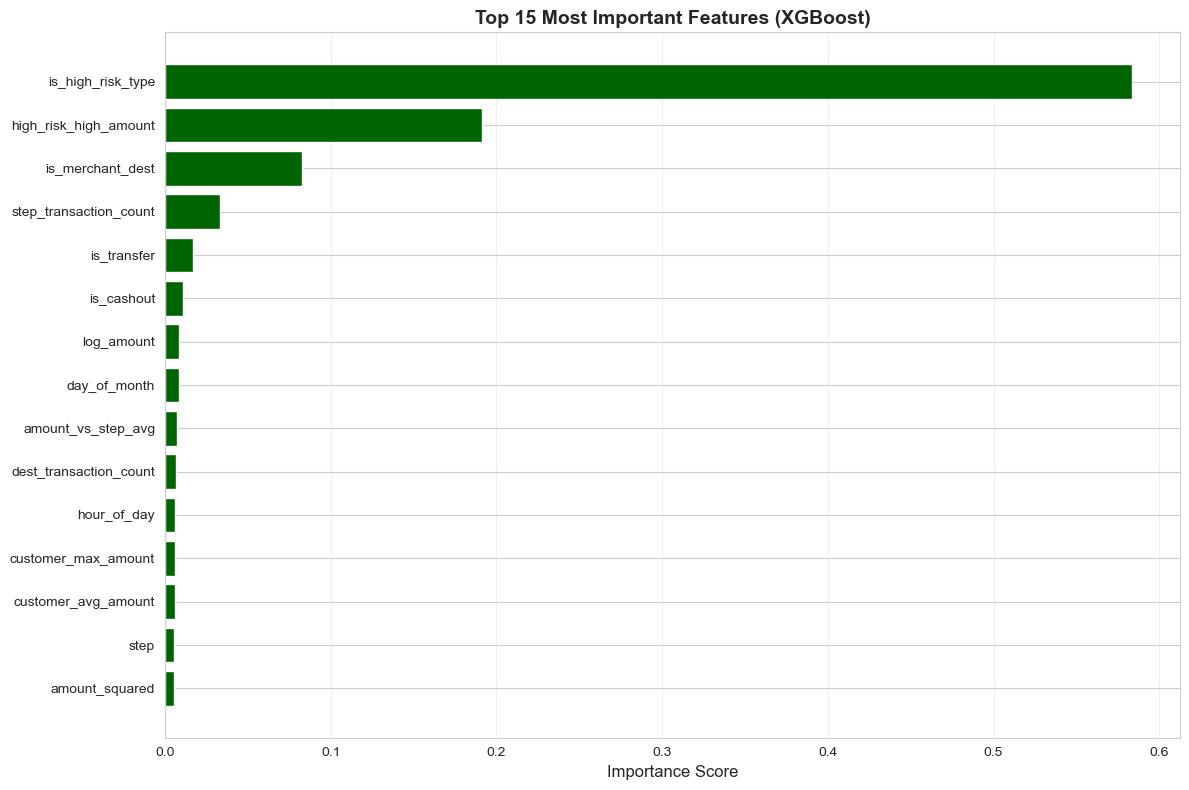

In [83]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Random Forest Feature Importance
print("\n" + "-"*80)
print("Random Forest Feature Importance")
print("-"*80)

feature_importance_rf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTOP 15 MOST IMPORTANT FEATURES (Random Forest)")
print(feature_importance_rf.head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_features_rf = feature_importance_rf.head(15)
plt.barh(range(len(top_features_rf)), top_features_rf['Importance'], color='steelblue')
plt.yticks(range(len(top_features_rf)), top_features_rf['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 15 Most Important Features (Random Forest)', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# LightGBM Feature Importance
print("\n" + "-"*80)
print("LightGBM Feature Importance")
print("-"*80)

feature_importance_lgb = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': lgbm.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTOP 15 MOST IMPORTANT FEATURES (LightGBM)")
print(feature_importance_lgb.head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_features_lgb = feature_importance_lgb.head(15)
plt.barh(range(len(top_features_lgb)), top_features_lgb['Importance'], color='purple')
plt.yticks(range(len(top_features_lgb)), top_features_lgb['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 15 Most Important Features (LightGBM)', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# XGBoost Feature Importance
print("\n" + "-"*80)
print("XGBoost Feature Importance")
print("-"*80)

feature_importance_xgb = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTOP 15 MOST IMPORTANT FEATURES (XGBoost)")
print(feature_importance_xgb.head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_features_xgb = feature_importance_xgb.head(15)
plt.barh(range(len(top_features_xgb)), top_features_xgb['Importance'], color='darkgreen')
plt.yticks(range(len(top_features_xgb)), top_features_xgb['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 15 Most Important Features (XGBoost)', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------
Feature Importance Consensus Across Models
--------------------------------------------------------------------------------

TOP 15 FEATURES BY AVERAGE RANK ACROSS ALL MODELS
               Feature  Avg_Rank  RF_Rank  XGB_Rank  LGB_Rank
step_transaction_count  2.666667      1.0       4.0       3.0
           is_transfer  6.333333      3.0       5.0      11.0
     is_high_risk_type  6.333333      2.0       1.0      16.0
    amount_vs_step_avg  6.666667     10.0       9.0       1.0
dest_transaction_count  6.666667      6.0      10.0       4.0
                  step  8.000000      8.0      14.0       2.0
            log_amount  8.000000      5.0       7.0      12.0
          day_of_month  9.000000      9.0       8.0      10.0
           hour_of_day 10.000000     11.0      11.0       8.0
   customer_max_amount 10.000000     12.0      12.0       6.0
                amount 10.666667      7.0      18.0       7.0

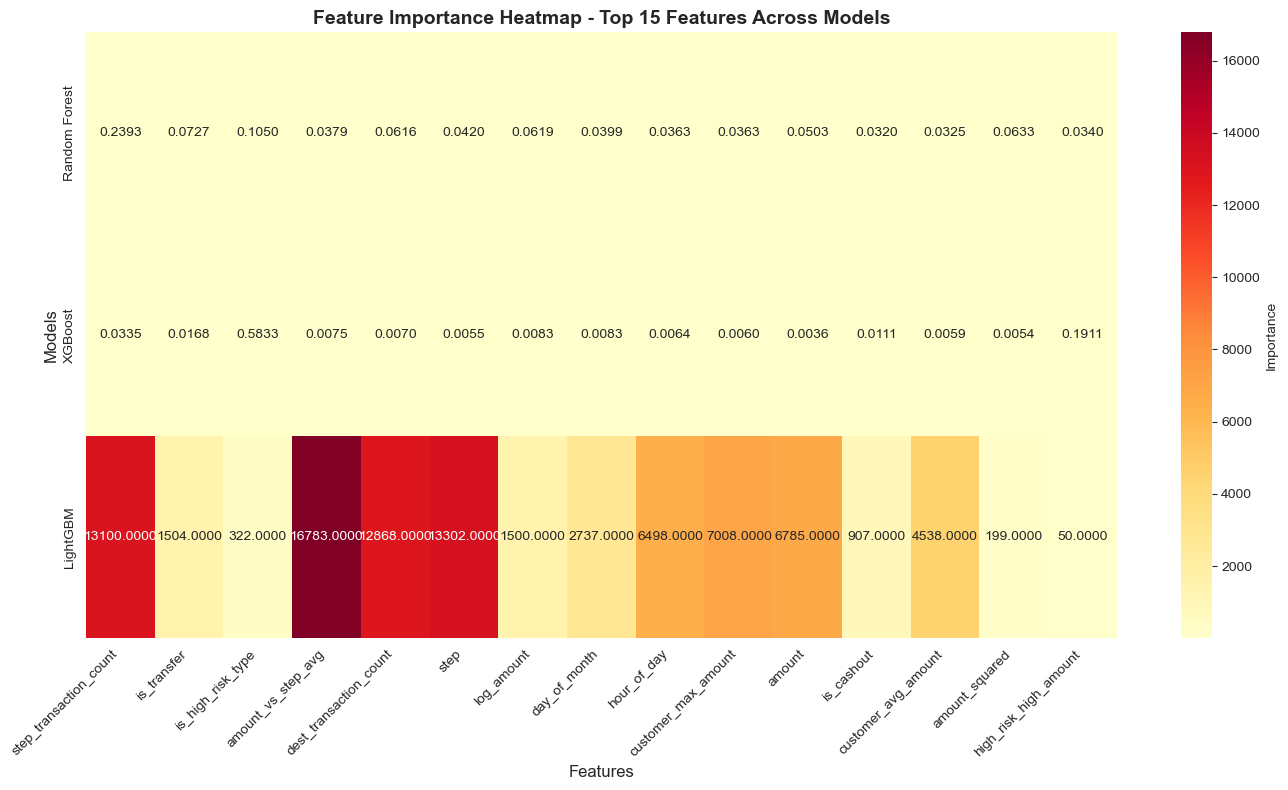

In [86]:
# Compare top features across models
print("\n" + "-"*80)
print("Feature Importance Consensus Across Models")
print("-"*80)

# Combine and rank features
combined_importance = pd.DataFrame({
    'Feature': feature_cols,
    'RF_Importance': rf_model.feature_importances_,
    'XGB_Importance': xgb.feature_importances_,
    'LGB_Importance': lgbm.feature_importances_
})

# Calculate average rank
combined_importance['RF_Rank'] = combined_importance['RF_Importance'].rank(ascending=False)
combined_importance['XGB_Rank'] = combined_importance['XGB_Importance'].rank(ascending=False)
combined_importance['LGB_Rank'] = combined_importance['LGB_Importance'].rank(ascending=False)
combined_importance['Avg_Rank'] = combined_importance[['RF_Rank', 'XGB_Rank', 'LGB_Rank']].mean(axis=1)

combined_importance = combined_importance.sort_values('Avg_Rank')

print("\nTOP 15 FEATURES BY AVERAGE RANK ACROSS ALL MODELS")
print(combined_importance[['Feature', 'Avg_Rank', 'RF_Rank', 'XGB_Rank', 'LGB_Rank']].head(15).to_string(index=False))

# Visualization: Feature importance heatmap
plt.figure(figsize=(14, 8))
top_15_features = combined_importance.head(15)['Feature'].values
heatmap_data = []
for feature in top_15_features:
    row = combined_importance[combined_importance['Feature'] == feature]
    heatmap_data.append([
        row['RF_Importance'].values[0],
        row['XGB_Importance'].values[0],
        row['LGB_Importance'].values[0]
    ])

heatmap_df = pd.DataFrame(heatmap_data, 
                          columns=['Random Forest', 'XGBoost', 'LightGBM'],
                          index=top_15_features)

sns.heatmap(heatmap_df.T, annot=True, fmt='.4f', cmap='YlOrRd', cbar_kws={'label': 'Importance'})
plt.title('Feature Importance Heatmap - Top 15 Features Across Models', fontweight='bold', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 10. Business Impact Analysis

In [88]:
print("\n" + "="*80)
print("BUSINESS IMPACT ANALYSIS")
print("="*80)

# Define business costs
AVG_FRAUD_AMOUNT = df[df['isFraud']==1]['amount'].mean()  # From EDA: ~$1.47M
MANUAL_REVIEW_COST = 50.0  # Cost per transaction review

print(f"\nBUSINESS ASSUMPTIONS:")
print(f"   Average fraud amount: ${AVG_FRAUD_AMOUNT:,.2f}")
print(f"   Manual review cost per transaction: ${MANUAL_REVIEW_COST:,.2f}")

# Use LightGBM model (best performer)
print("\n" + "-"*80)
print("SELECTING LIGHTGBM AS PRODUCTION MODEL")
print("-"*80)
print("- Highest ROC-AUC and Average Precision")
print("- Best F2 score (prioritizes recall)")
print("- Efficient for real-time deployment")

# Get predictions with optimal threshold
y_test_pred_lgb = (y_test_proba_lgb >= best_t_lgb).astype(int)

# Calculate confusion matrix
cm_final = confusion_matrix(y_test, y_test_pred_lgb)
tn, fp, fn, tp = cm_final.ravel()

# Business metrics
total_fraud = y_test.sum()
detected_fraud = tp
missed_fraud = fn
false_alarms = fp

fraud_prevented_amount = tp * AVG_FRAUD_AMOUNT
fraud_loss_amount = fn * AVG_FRAUD_AMOUNT
review_cost_amount = (tp + fp) * MANUAL_REVIEW_COST  # Review all flagged transactions
net_benefit = fraud_prevented_amount - review_cost_amount

print("\n" + "="*80)
print("FINAL BUSINESS IMPACT ANALYSIS")
print("="*80)

print(f"\nDETECTION PERFORMANCE:")
print(f"   Total fraudulent transactions: {total_fraud:,}")
print(f"   Frauds detected: {detected_fraud:,} ({(detected_fraud/total_fraud) * 100:.1f}%)")
print(f"   Frauds missed: {missed_fraud:,} ({(missed_fraud/total_fraud) * 100:.1f}%)")
print(f"   False alarms: {false_alarms:,} ({false_alarms/len(y_test)*100:.3f}% of all transactions)")

print(f"\nFINANCIAL IMPACT:")
print(f"   Average fraud amount: ${AVG_FRAUD_AMOUNT:,.2f}")
print(f"   Fraud prevented: ${fraud_prevented_amount:,.2f}")
print(f"   Fraud losses (missed): ${fraud_loss_amount:,.2f}")
print(f"   Manual review costs: ${review_cost_amount:,.2f}")
print(f"   ")
print(f"   NET BENEFIT: ${net_benefit:,.2f}")
print(f"   ROI: {(fraud_prevented_amount / review_cost_amount) if review_cost_amount > 0 else float('inf'):.1f}x")

print(f"\nCOST-BENEFIT RATIO:")
prevented_to_lost = fraud_prevented_amount / fraud_loss_amount if fraud_loss_amount > 0 else float('inf')
print(f"   ${prevented_to_lost:.1f} prevented for every $1 lost to fraud")

# Additional business metrics
total_fraud_value = total_fraud * AVG_FRAUD_AMOUNT
fraud_recovery_rate = (fraud_prevented_amount / total_fraud_value) * 100

print(f"\nADDITIONAL METRICS:")
print(f"   Total fraud value in test set: ${total_fraud_value:,.2f}")
print(f"   Fraud recovery rate: {fraud_recovery_rate:.1f}%")
print(f"   Cost per fraud detected: ${review_cost_amount / detected_fraud if detected_fraud > 0 else 0:,.2f}")
print(f"   False positive rate: {fp / (fp + tn) * 100:.3f}%")
print(f"   Precision (of flagged transactions): {tp / (tp + fp) * 100 if (tp + fp) > 0 else 0:.1f}%")


BUSINESS IMPACT ANALYSIS

BUSINESS ASSUMPTIONS:
   Average fraud amount: $1,467,967.30
   Manual review cost per transaction: $50.00

--------------------------------------------------------------------------------
SELECTING LIGHTGBM AS PRODUCTION MODEL
--------------------------------------------------------------------------------
- Highest ROC-AUC and Average Precision
- Best F2 score (prioritizes recall)
- Efficient for real-time deployment

FINAL BUSINESS IMPACT ANALYSIS

DETECTION PERFORMANCE:
   Total fraudulent transactions: 1,643
   Frauds detected: 1,138 (69.3%)
   Frauds missed: 505 (30.7%)
   False alarms: 471 (0.037% of all transactions)

FINANCIAL IMPACT:
   Average fraud amount: $1,467,967.30
   Fraud prevented: $1,670,546,786.42
   Fraud losses (missed): $741,323,486.07
   Manual review costs: $80,450.00
   
   NET BENEFIT: $1,670,466,336.42
   ROI: 20765.0x

COST-BENEFIT RATIO:
   $2.3 prevented for every $1 lost to fraud

ADDITIONAL METRICS:
   Total fraud value in t

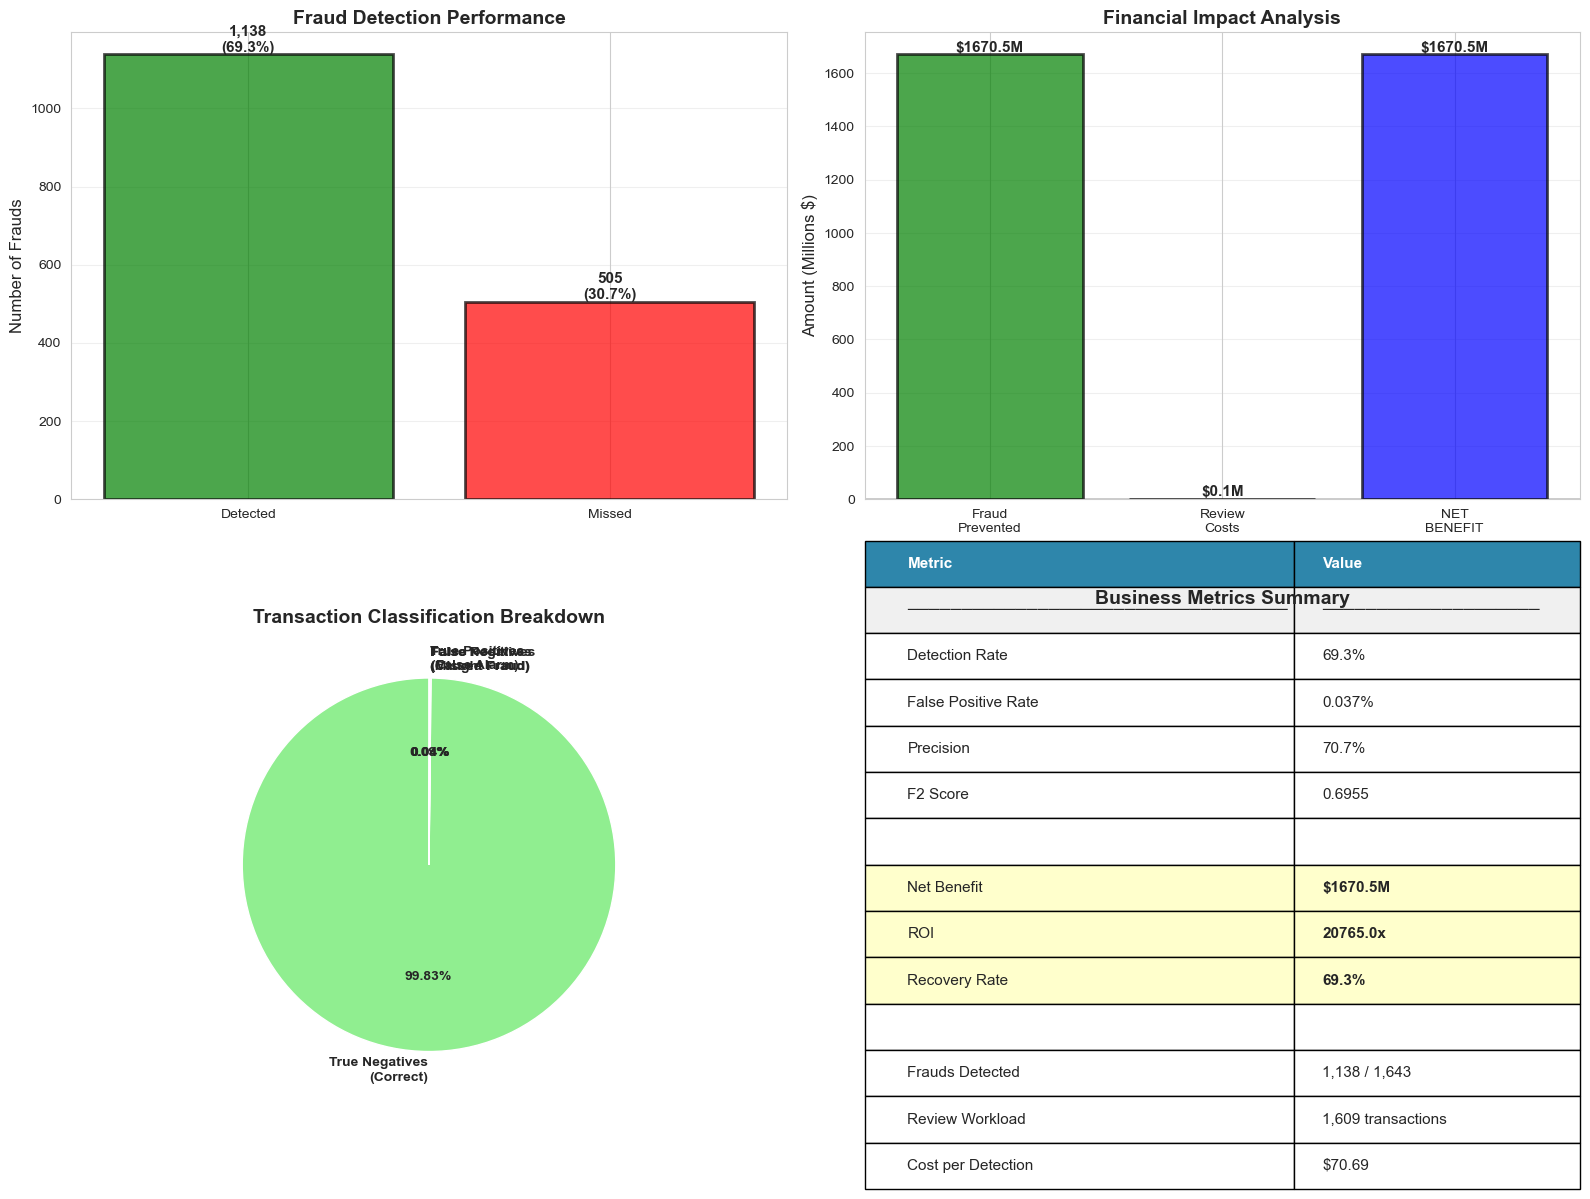

In [90]:
# Visualization: Business Impact Dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Detection Performance
ax = axes[0, 0]
categories = ['Detected', 'Missed']
values = [detected_fraud, missed_fraud]
colors = ['green', 'red']
bars = ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Frauds', fontsize=12)
ax.set_title('Fraud Detection Performance', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}\n({val/total_fraud*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# 2. Financial Impact
ax = axes[0, 1]
categories = ['Fraud\nPrevented', 'Review\nCosts', 'NET\nBENEFIT']
values = [fraud_prevented_amount/1e6, review_cost_amount/1e6, net_benefit/1e6]
colors = ['green', 'orange', 'blue']
bars = ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Amount (Millions $)', fontsize=12)
ax.set_title('Financial Impact Analysis', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${val:.1f}M',
            ha='center', va='bottom' if val > 0 else 'top', fontweight='bold', fontsize=11)

# 3. Transaction Breakdown
ax = axes[1, 0]
transaction_data = {
    'True Negatives\n(Correct)': tn,
    'False Positives\n(False Alarm)': fp,
    'False Negatives\n(Missed Fraud)': fn,
    'True Positives\n(Caught Fraud)': tp
}
colors_conf = ['lightgreen', 'lightyellow', 'lightcoral', 'darkgreen']
wedges, texts, autotexts = ax.pie(transaction_data.values(), 
                                    labels=transaction_data.keys(),
                                    colors=colors_conf,
                                    autopct=lambda pct: f'{pct:.2f}%',
                                    startangle=90,
                                    textprops={'fontsize': 10, 'fontweight': 'bold'})
ax.set_title('Transaction Classification Breakdown', fontweight='bold', fontsize=14)

# 4. Key Metrics Summary
ax = axes[1, 1]
ax.axis('off')

metrics_summary = [
    ['Metric', 'Value'],
    ['─'*35, '─'*20],
    ['Detection Rate', f'{detected_fraud/total_fraud*100:.1f}%'],
    ['False Positive Rate', f'{fp/(fp+tn)*100:.3f}%'],
    ['Precision', f'{tp/(tp+fp)*100 if (tp+fp)>0 else 0:.1f}%'],
    ['F2 Score', f'{fbeta_score(y_test, y_test_pred_lgb, beta=2):.4f}'],
    ['', ''],
    ['Net Benefit', f'${net_benefit/1e6:.1f}M'],
    ['ROI', f'{fraud_prevented_amount/review_cost_amount if review_cost_amount>0 else 0:.1f}x'],
    ['Recovery Rate', f'{fraud_recovery_rate:.1f}%'],
    ['', ''],
    ['Frauds Detected', f'{detected_fraud:,} / {total_fraud:,}'],
    ['Review Workload', f'{fp+tp:,} transactions'],
    ['Cost per Detection', f'${review_cost_amount/detected_fraud if detected_fraud>0 else 0:,.2f}']
]

table = ax.table(cellText=metrics_summary,
                cellLoc='left',
                loc='center',
                colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header
table[(0, 0)].set_facecolor('#2E86AB')
table[(0, 1)].set_facecolor('#2E86AB')
table[(0, 0)].set_text_props(weight='bold', color='white')
table[(0, 1)].set_text_props(weight='bold', color='white')

# Style separator row
table[(1, 0)].set_facecolor('#f0f0f0')
table[(1, 1)].set_facecolor('#f0f0f0')

# Highlight key metrics
for i in [7, 8, 9]:
    table[(i, 0)].set_facecolor('#FFFFCC')
    table[(i, 1)].set_facecolor('#FFFFCC')
    table[(i, 1)].set_text_props(weight='bold')

ax.set_title('Business Metrics Summary', fontweight='bold', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

## 11. Final Recommendations

In [94]:
# FINAL RECOMMENDATIONS

print("\n" + "="*80)
print("PRODUCTION DEPLOYMENT RECOMMENDATIONS")
print("="*80)

print("\nMODEL SELECTION: LightGBM")
print(f"   • Detection rate: {detected_fraud/total_fraud*100:.1f}%")
print(f"   • False positive rate: {fp/(fp+tn)*100:.3f}%")
print(f"   • Optimal threshold: {best_t_lgb:.3f}")
print(f"   • Expected net benefit: ${net_benefit:,.2f}")

print("\nIMPLEMENTATION STRATEGY:")
print("   1. Deploy LightGBM model with threshold =", f"{best_t_lgb:.3f}")
print("   2. Flag", f"{(tp+fp):,}", "transactions for manual review")
print("   3. Expected to catch", f"{detected_fraud:,}/{total_fraud:,}", "frauds")
print("   4. Review team needs capacity for", f"{fp+tp:,}", "daily reviews")

print("\nMONITORING RECOMMENDATIONS:")
print("   • Track false positive rate weekly (target: <0.5%)")
print("   • Monitor fraud detection rate (target: >75%)")
print("   • Review threshold quarterly based on fraud patterns")
print("   • A/B test with champion-challenger approach")

print("\nFUTURE IMPROVEMENTS:")
print("   • Add real-time velocity features")
print("   • Implement graph-based network analysis")
print("   • Deploy SHAP for model explainability")
print("   • Develop customer-specific risk profiles")
print("   • Consider ensemble with deep learning models")

print("\n" + "="*80)


PRODUCTION DEPLOYMENT RECOMMENDATIONS

MODEL SELECTION: LightGBM
   • Detection rate: 69.3%
   • False positive rate: 0.037%
   • Optimal threshold: 0.970
   • Expected net benefit: $1,670,466,336.42

IMPLEMENTATION STRATEGY:
   1. Deploy LightGBM model with threshold = 0.970
   2. Flag 1,609 transactions for manual review
   3. Expected to catch 1,138/1,643 frauds
   4. Review team needs capacity for 1,609 daily reviews

MONITORING RECOMMENDATIONS:
   • Track false positive rate weekly (target: <0.5%)
   • Monitor fraud detection rate (target: >75%)
   • Review threshold quarterly based on fraud patterns
   • A/B test with champion-challenger approach

FUTURE IMPROVEMENTS:
   • Add real-time velocity features
   • Implement graph-based network analysis
   • Deploy SHAP for model explainability
   • Develop customer-specific risk profiles
   • Consider ensemble with deep learning models

